# Exploratory Data Analysis

#### Imports

In [1]:
from datetime import datetime as dt
from scipy import stats
from sqlalchemy import create_engine
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from db_utils import RDSDatabaseConnector, DataTransform, DataFrameInfo, Plotter, DataFrameTransform

def read_crednetials():
    with open('credentials.yaml','r') as f:
        cred_dict = yaml.safe_load(f)
    return cred_dict

def create_csv_file(df):
    df.to_csv('local_csv_file.csv')


#### Getting the data

In [2]:
cred_dict = read_crednetials()
test = RDSDatabaseConnector(cred_dict)
pd.set_option('display.max_columns', None)
df = test.get_loan_payments_df()

#### Cleaning the data

In [3]:
test_transform = DataTransform(df)
test_transform.transform()
test_dateframeinfo = DataFrameInfo(test_transform.df)
test_dataframetransform = DataFrameTransform(test_transform.df)
test_dataframetransform.drop_columns()
test_dataframetransform.impute()

#### Removing outliers

In [4]:
test_dataframetransform.skew_data()
outliers = test_dataframetransform.outliers()
test_dataframetransform.remove_outliers(outliers)

Initial data length: 54100
Initial outliers count: 17024
Max allowed loss: 2705.0
Current data length: 37928
Current outliers count: 16172
Current data loss: 16172


,id,member_id,loan_amount,funded_amount,funded_amount_inv,term (months),int_rate,instalment,grade,sub_grade,employment_length (years),home_ownership,annual_inc,verification_status,issue_date,loan_status,payment_plan,purpose,dti,delinq_2yrs,earliest_credit_line,inq_last_6mths,open_accounts,total_accounts,out_prncp,out_prncp_inv,total_payment,total_payment_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,policy_code,application_type,loan_amount_skew,funded_amount_skew,funded_amount_inv_skew,term (months)_skew,int_rate_skew,instalment_skew,employment_length (years)_skew,annual_inc_skew,dti_skew,delinq_2yrs_skew,inq_last_6mths_skew,open_accounts_skew,total_accounts_skew,out_prncp_skew,out_prncp_inv_skew,total_payment_skew,total_payment_inv_skew,total_rec_prncp_skew,total_rec_int_skew,total_rec_late_fee_skew,recoveries_skew,collection_recovery_fee_skew,last_payment_amount_skew,collections_12_mths_ex_med_skew,policy_code_skew
0,38676116,41461848,8000,8000.0,8000.000000,36.0,7.49,248.82,A,A4,5.0,MORTGAGE,46000.0,Not Verified,2021-01-01 00:00:00,Current,n,credit_card,19.54,2,1987-10-01 00:00:00,1,12,27,5529.70,5529.70,2982.51,2982.51,2470.30,512.21,0.0,0.0,0.0,Jan-2022,248.82,2022-02-01,Jan-2022,0.0,1,INDIVIDUAL,68.035129,78.556304,118.808946,0.140315,3.491564,16.117665,3.882537,7.855343,11.816312,0.141374,0.520625,3.406803,6.684991,4.282476,4.282144,33.058073,50.632074,32.733737,10.799539,-0.0,-0.0,-0.0,4.910558,-0.0,50.772477
1,38656203,41440010,13200,13200.0,13200.000000,36.0,6.99,407.52,A,A3,9.0,RENT,50000.0,Not Verified,2021-01-01 00:00:00,Current,n,credit_card,24.20,0,2001-09-01 00:00:00,0,15,31,9102.83,9102.83,4885.11,4885.11,4097.17,787.94,0.0,0.0,0.0,Jan-2022,407.52,2022-02-01,Jan-2022,0.0,1,INDIVIDUAL,82.041964,95.675594,148.884050,0.140315,3.342498,19.560310,6.394722,7.898277,14.029700,-0.000000,-0.000000,3.772212,7.168597,4.377575,4.377222,38.824549,61.433536,38.795430,12.024962,-0.0,-0.0,-0.0,5.293713,-0.0,50.772477
2,38656154,41439961,16000,16000.0,16000.000000,36.0,7.49,497.63,A,A4,8.0,MORTGAGE,73913.0,Source Verified,2021-01-01 00:00:00,Fully Paid,n,credit_card,16.92,0,1998-09-01 00:00:00,0,7,18,0.00,0.00,16824.54,16824.54,16000.00,824.54,0.0,0.0,0.0,Oct-2021,12850.16,2022-02-01,Oct-2021,0.0,1,INDIVIDUAL,88.131721,103.173670,162.331777,0.140315,3.491564,21.126551,5.792200,8.096621,10.519817,-0.000000,-0.000000,2.612569,5.411589,-0.000000,-0.000000,57.617635,99.131280,60.694174,12.159244,-0.0,-0.0,-0.0,7.763081,-0.0,50.772477
3,38656128,41439934,15000,15000.0,15000.000000,36.0,14.31,514.93,C,C4,1.0,RENT,42000.0,Source Verified,2021-01-01 00:00:00,Fully Paid,n,debt_consolidation,35.52,0,2008-06-01 00:00:00,0,6,13,0.00,0.00,15947.47,15947.47,15000.00,947.47,0.0,0.0,0.0,Jun-2021,13899.67,2022-02-01,Jun-2021,0.0,1,INDIVIDUAL,86.041427,100.596458,157.691853,0.140315,5.159099,21.405263,0.917631,7.808250,19.042110,-0.000000,-0.000000,2.408069,4.532350,-0.000000,-0.000000,56.652599,97.112981,59.436528,12.576487,-0.0,-0.0,-0.0,7.815112,-0.0,50.772477
4,38656121,41439927,15000,15000.0,15000.000000,36.0,6.03,456.54,A,A1,10.0,MORTGAGE,145000.0,Verified,2021-01-01 00:00:00,Current,n,debt_consolidation,3.33,0,2002-04-01 00:00:00,1,23,50,10297.47,10297.47,5473.46,5473.46,4702.53,770.93,0.0,0.0,0.0,Jan-2022,456.54,2022-02-01,Jan-2022,0.0,1,INDIVIDUAL,86.041427,100.596458,157.691853,0.140315,3.040496,20.437849,6.983807,8.427553,2.696704,-0.000000,0.520625,4.533787,9.061771,4.399768,4.399410,40.278205,64.218647,40.616774,11.960769,-0.0,-0.0,-0.0,5.380851,-0.0,50.772477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54188,55742,114426,7000,7000.0,672.803839,36.0,10.71,228.22,B,B5,0.0,

## Analysis and Visualisation

#### Current state of the loans

In [5]:
test_df = test_dataframetransform.df.copy()
new_df =  test_df.copy()
new_df['recovery_percentage'] = (new_df['total_payment'] / new_df['funded_amount']) * 100
for i in range(1, 7):
    condition_current = (new_df['loan_status'] == 'Current') & (new_df['out_prncp'] > 0)
    new_df.loc[condition_current, 'recovery_percentage in ' + str(i) + ' months'] = ((new_df['total_payment'] + (new_df['last_payment_amount'] * (i))) / new_df['funded_amount']) * 100
    new_df.loc[condition_current, 'total_payment in ' + str(i) + ' months'] = new_df['total_payment'] + (new_df['last_payment_amount'] * (i))
    total_payment_col = 'total_payment in ' + str(i) + ' months'
    new_df[total_payment_col] = new_df['total_payment'].where(new_df['loan_status'] != 'Current', new_df[total_payment_col])
    total_payment_col = 'total_payment in ' + str(i) + ' months'
    new_df[total_payment_col] = new_df[total_payment_col].fillna(new_df['total_payment'])
    recovery_col = 'recovery_percentage in ' + str(i) + ' months'
    new_df[recovery_col] = new_df['recovery_percentage'].where(new_df['loan_status'] != 'Current', new_df[recovery_col])
overall_recovery_percentage = (new_df['total_payment'].sum() / new_df['funded_amount'].sum()) * 100
overall_recovery_percentage_fut = (new_df['total_payment in 6 months'].sum() / new_df['funded_amount'].sum()) * 100
print(f'overall recovery percentage now is {overall_recovery_percentage}, in six months it will be {overall_recovery_percentage_fut}')

overall recovery percentage now is 94.39674970379728, in six months it will be 102.09052959169895


#### Calculating loss

In [6]:
new_df.loc[:, 'loss'] = new_df['funded_amount'] - new_df['total_payment'] 
overall_charged_off_percentage = (len(new_df[new_df['loan_status'].isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'])]['loan_status']) / len(new_df['loan_status'])) * 100
overall_charged_off_loss = new_df[new_df['loan_status'].isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'])]['loss'].sum()
print(f'overall_charged_off_percentage is: {overall_charged_off_percentage}')
print(f'overall_charged_off_loss is: {overall_charged_off_loss}')

overall_charged_off_percentage is: 4.235688328849875
overall_charged_off_loss is: 14103178.803520784


#### Calculating projected loss

In [7]:
condition_current = new_df['loan_status'] == 'Charged Off'
new_df.loc[condition_current, 'expected_return'] = new_df['funded_amount'] * (new_df['int_rate'] / 100) * (new_df['term (months)'] / 12)
expected_return = new_df[condition_current]['expected_return'].sum()
actual_return = new_df[condition_current]['total_payment'].sum()
percentage_lost = ((expected_return - actual_return) / expected_return) * 100
increase_in_revenue = expected_return - actual_return
print(expected_return)
print(actual_return)
print(percentage_lost)
print(increase_in_revenue)


14407050.41423896
9780376.9999276
32.11395310825501
4626673.414311359


#### Possible loss

In [8]:
percentage_of_late_loans = len(new_df[new_df['loan_status'].isin(['Late (16-30 days)', 'Late (31-120 days)'])]) / len(new_df) * 100
amount_of_late_customers = len(new_df[new_df['loan_status'].isin(['Late (16-30 days)', 'Late (31-120 days)'])])
projected_loss_of_loans = new_df[(new_df['loan_status'].isin(['Late (16-30 days)', 'Late (31-120 days)'])) & (new_df['loss'] > 0)]['loss'].sum()
cols = ['Late (16-30 days)', 'Late (31-120 days)','Charged Off', 'Does not meet the credit policy. Status:Charged Off']
percentage_of_total_revenue = new_df[new_df['loan_status'].isin(cols)]['total_payment'].sum() / new_df['total_payment'].sum() * 100
print(f'percentage of late loans = {percentage_of_late_loans}')
print(f'amount of late customers = {amount_of_late_customers}')
print(f'projected loss of loans = {projected_loss_of_loans}')
print(f'percentage of total revenue = {percentage_of_total_revenue}')

percentage of late loans = 1.087828590306291
amount of late customers = 461
projected loss of loans = 1814442.431453225
percentage of total revenue = 2.8912641417287133


#### Indicators of loss

In [11]:
# Indicators of loss
grade_mapping = {'A': 7.0, 'B': 6.0, 'C': 5.0, 'D': 4.0, 'E': 3.0, 'F': 2.0, 'G':1.0}
new_df['grade'] = new_df['grade'].map(grade_mapping)

charged_off_df


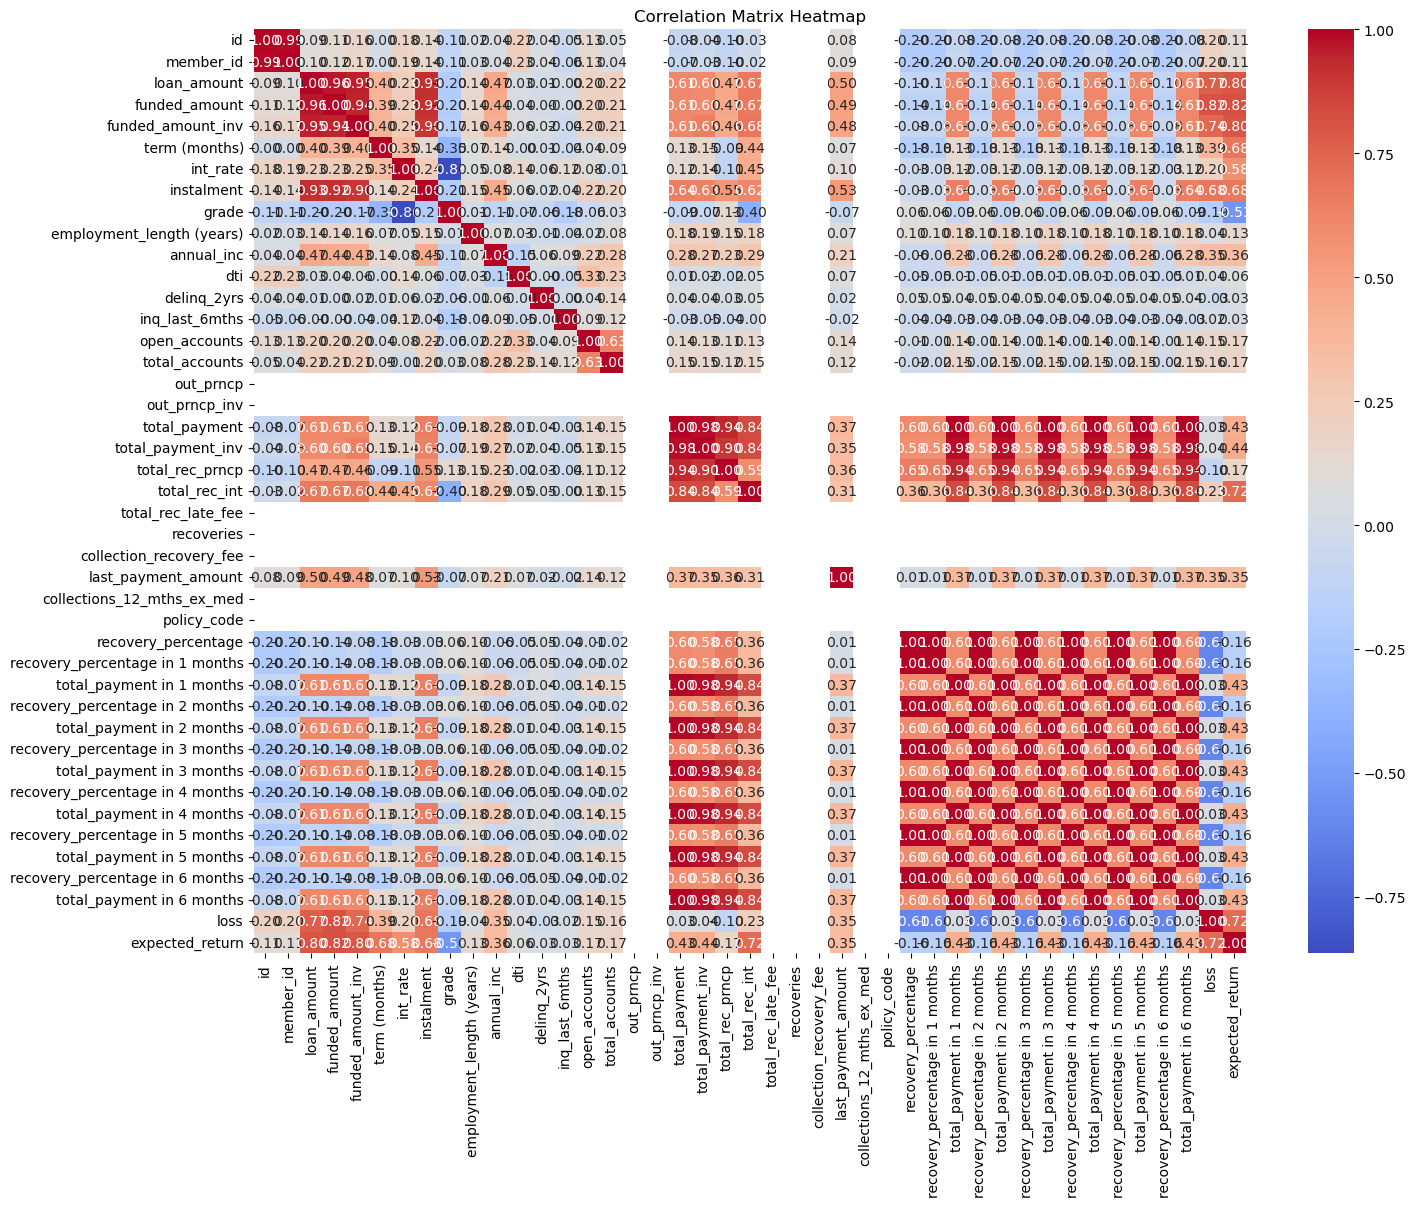

late_df


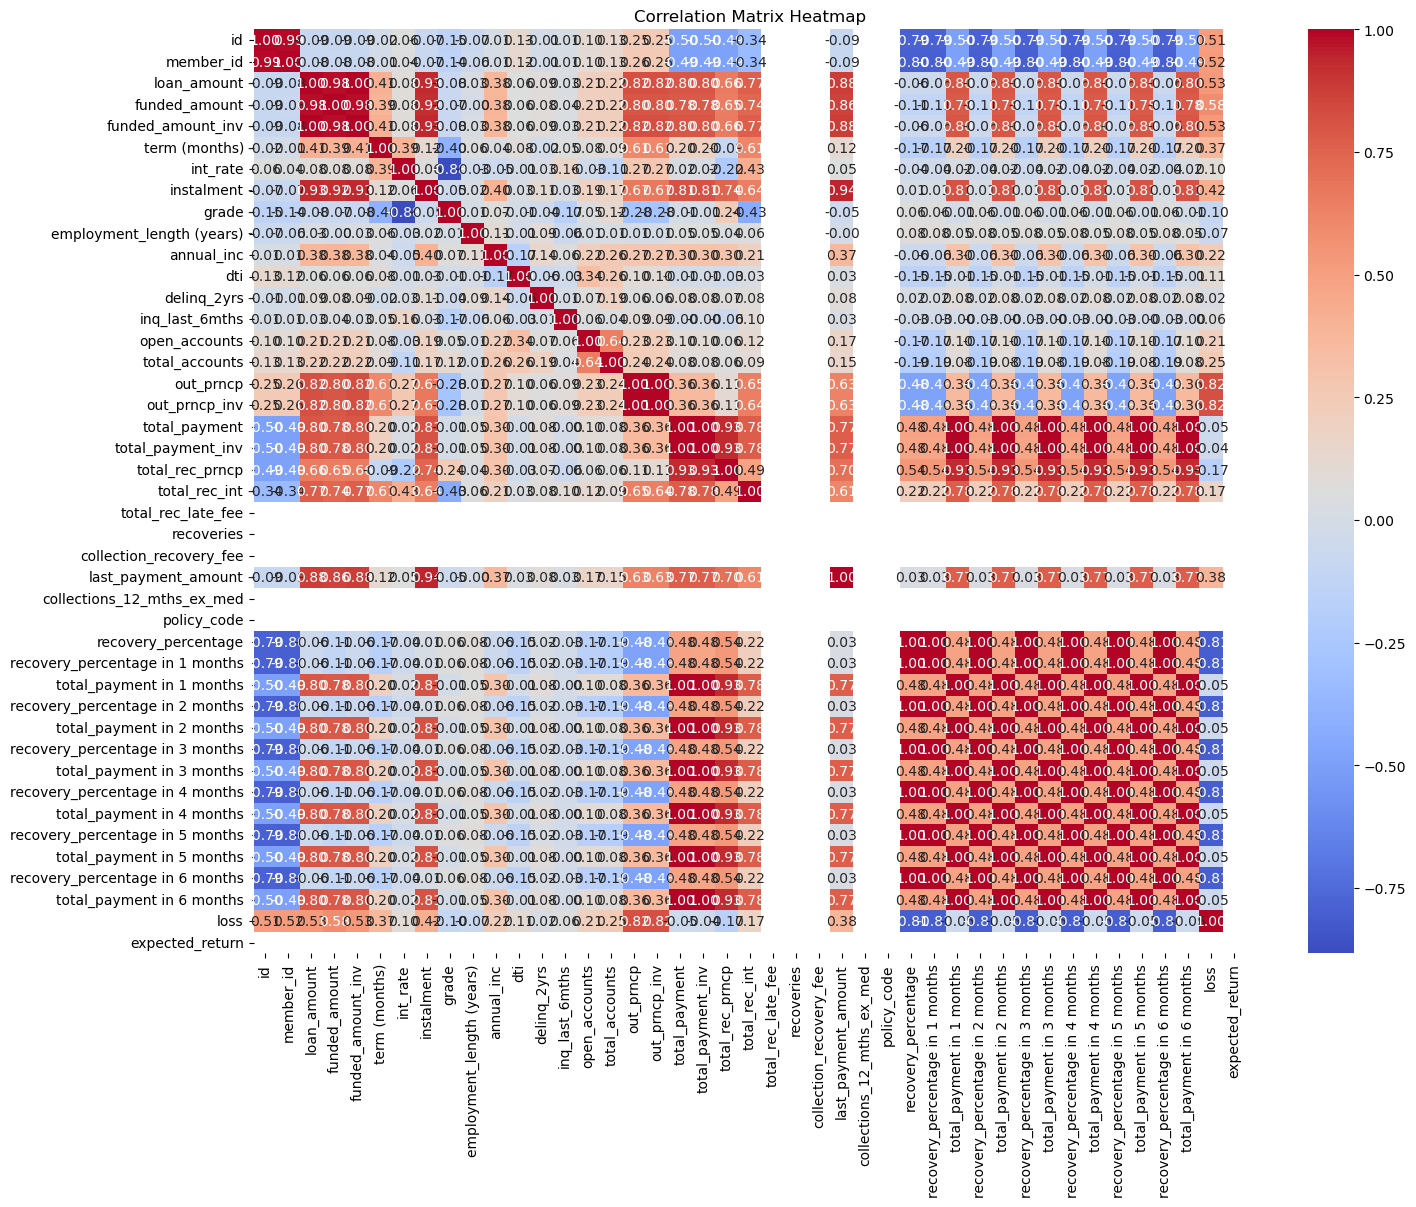

paid_df


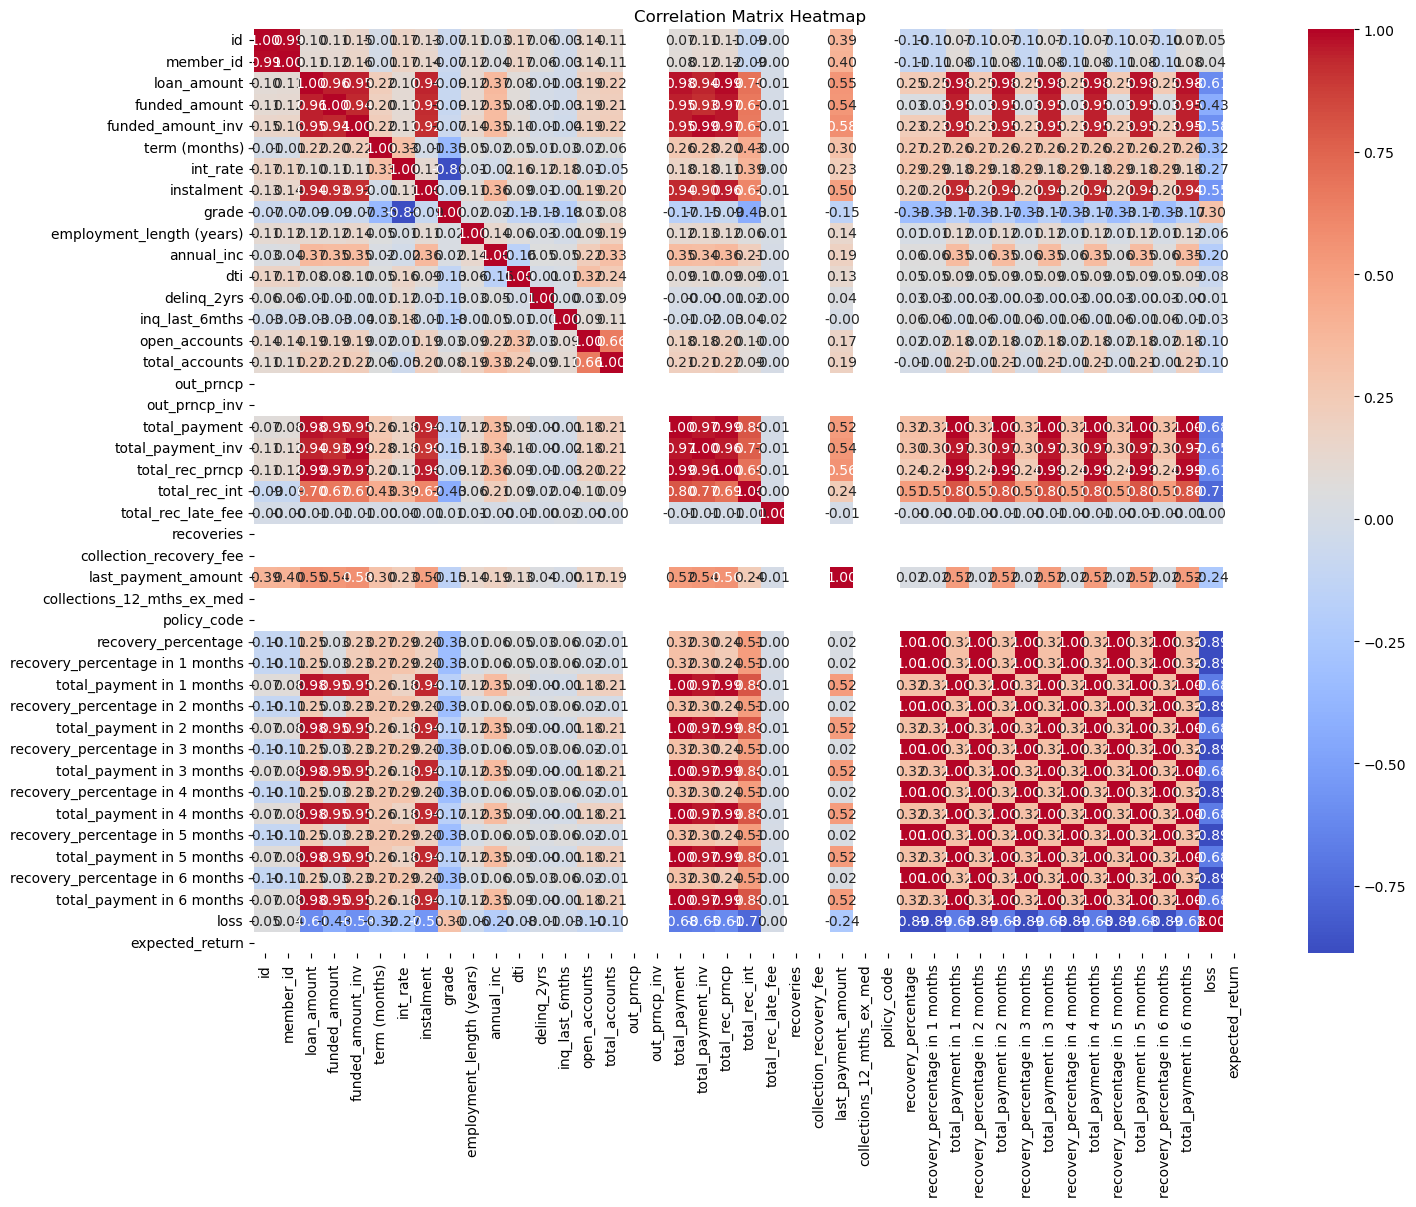

In [12]:
charged_off_df = new_df.loc[new_df['loan_status'].isin(['Charged Off', 'Does not meet the credit policy. Status:Charged Off']), :]  
late_df = new_df.loc[new_df['loan_status'].isin(['Late (16-30 days)', 'Late (31-120 days)']), :]
paid_df = new_df.loc[new_df['loan_status'].isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), :]
dfs = {'charged_off_df': charged_off_df, 'late_df': late_df, 'paid_df': paid_df}
for df_name, df in dfs.items():
    print(df_name)
    visual = Plotter(df)
    visual.correlation_visual()


An interesting obsivation from these graphs is that dti doesn't appear to be heavily correlated with the other columns. My inital intuition was that it would be so I thought this result was worth highlighting. I discuss some more interesting findings below as I continue my analysis.

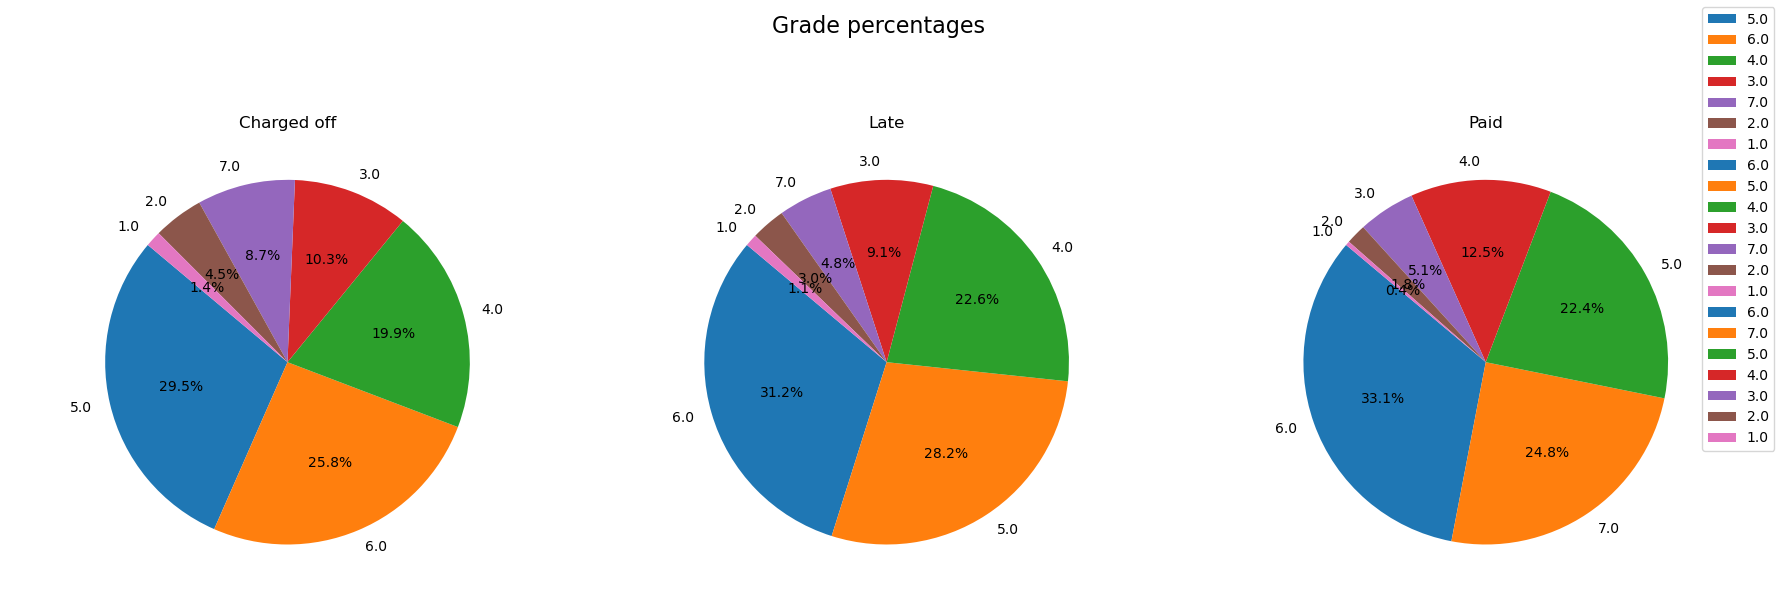

In [13]:
charged_count = charged_off_df['grade'].value_counts()
late_count = late_df['grade'].value_counts()
paid_count = paid_df['grade'].value_counts()
# The subplots grid is 1 x 3
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# charged off grades
ax1.pie(charged_count, labels=charged_count.index, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')
ax1.set_title('Charged off')  # Set title for ax1
ax1.grid(True)
# late grades
ax2.pie(late_count, labels=late_count.index, autopct='%1.1f%%', startangle=140)
ax2.axis('equal')
ax2.set_title('Late')
ax2.grid(True)
# paid grades
ax3.pie(paid_count, labels=paid_count.index, autopct='%1.1f%%', startangle=140)
ax3.axis('equal')
ax3.set_title('Paid')
ax3.grid(True)
# Add plot labels and legend to the entire figure
fig.suptitle('Grade percentages', fontsize=16)
fig.legend(loc='upper right')
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])
ax3.grid(True)
# Show the plot
plt.show()

In the graphs shown above, grade 7 (A) is clearly lower in the late and charged off graphs than in the paid one. Also there is a higher percentage of grades 1 to 3 (G to F) for the late and charged off status. This suggests that a lower grade is an indicator that a user might not pay their loan.

What is also worth noting is that in the correlation matrices, grade had a strong negative correlation with the Annual (APR) interest rate of the loan (int_rate). This further suggests that loans with a high interest rate are more likely to be late or charged off.

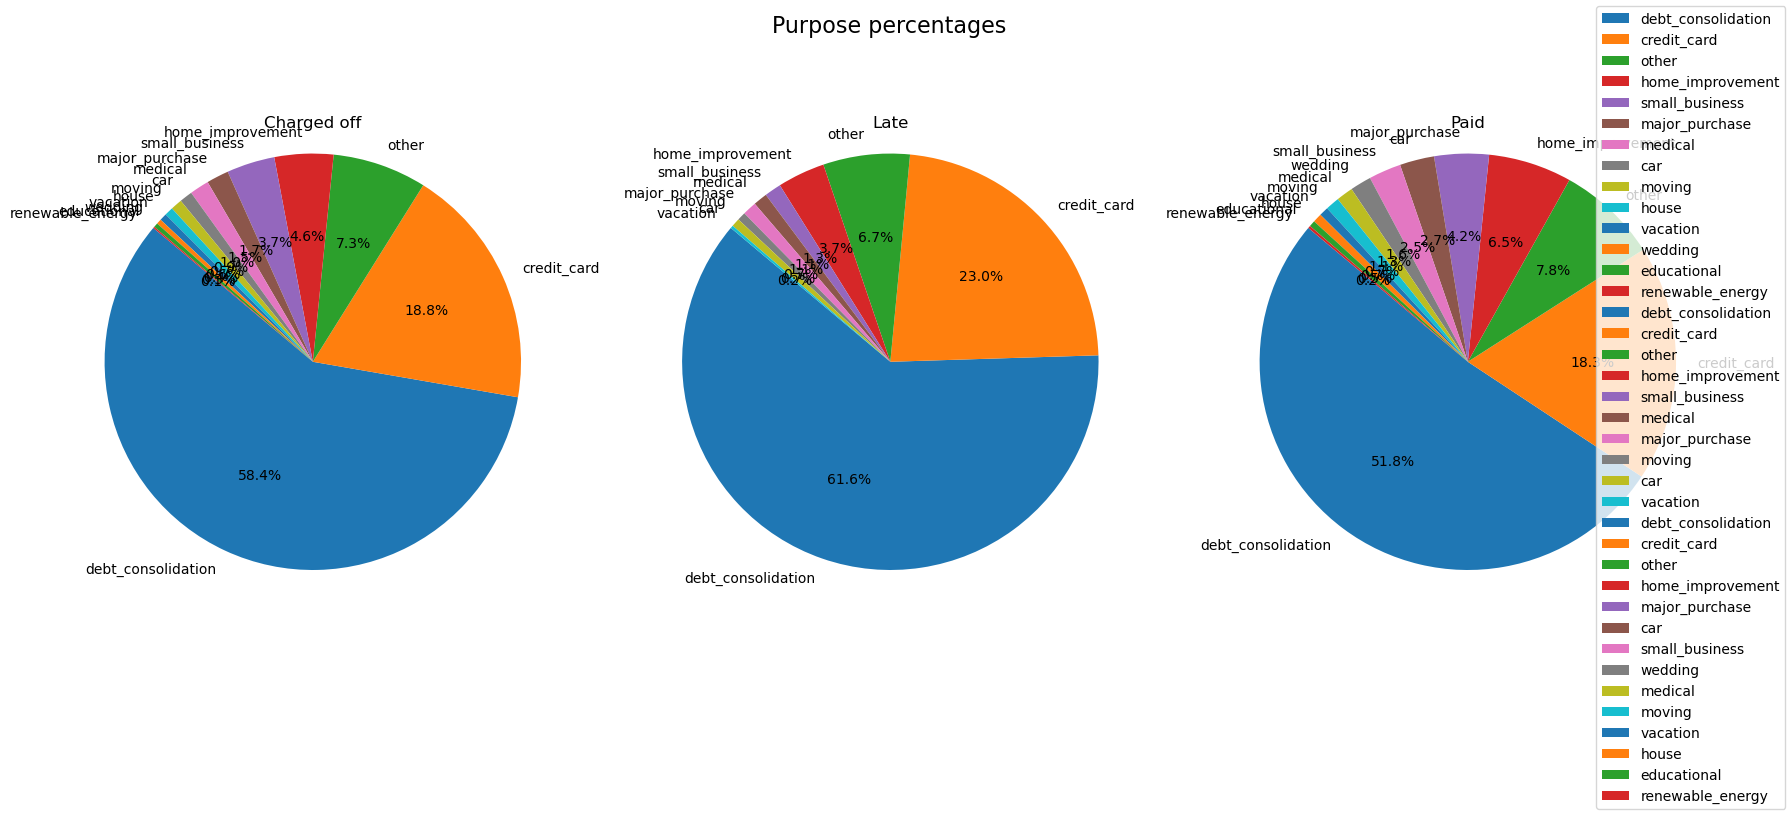

In [15]:
charged_count = charged_off_df['purpose'].value_counts()
late_count = late_df['purpose'].value_counts()
paid_count = paid_df['purpose'].value_counts()
# The subplots grid is 1 x 3
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# charged off grades
ax1.pie(charged_count, labels=charged_count.index, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')
ax1.set_title('Charged off')  # Set title for ax1
ax1.grid(True)
# late grades
ax2.pie(late_count, labels=late_count.index, autopct='%1.1f%%', startangle=140)
ax2.axis('equal')
ax2.set_title('Late')
ax2.grid(True)
# paid grades
ax3.pie(paid_count, labels=paid_count.index, autopct='%1.1f%%', startangle=140)
ax3.axis('equal')
ax3.set_title('Paid')
ax3.grid(True)
# Add plot labels and legend to the entire figure
fig.suptitle('Purpose percentages', fontsize=16)
fig.legend(loc='upper right')
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])
ax3.grid(True)
# Show the plot
plt.show()

This graph shows the reasons why the user took out the loan as percentages. Comparing the graph for paid to the other two, there is a clear reduction in the quanitity of debt consolidation. This suggests that the purpose of the loan could effect the likelihood of the user paying back their loan in full.

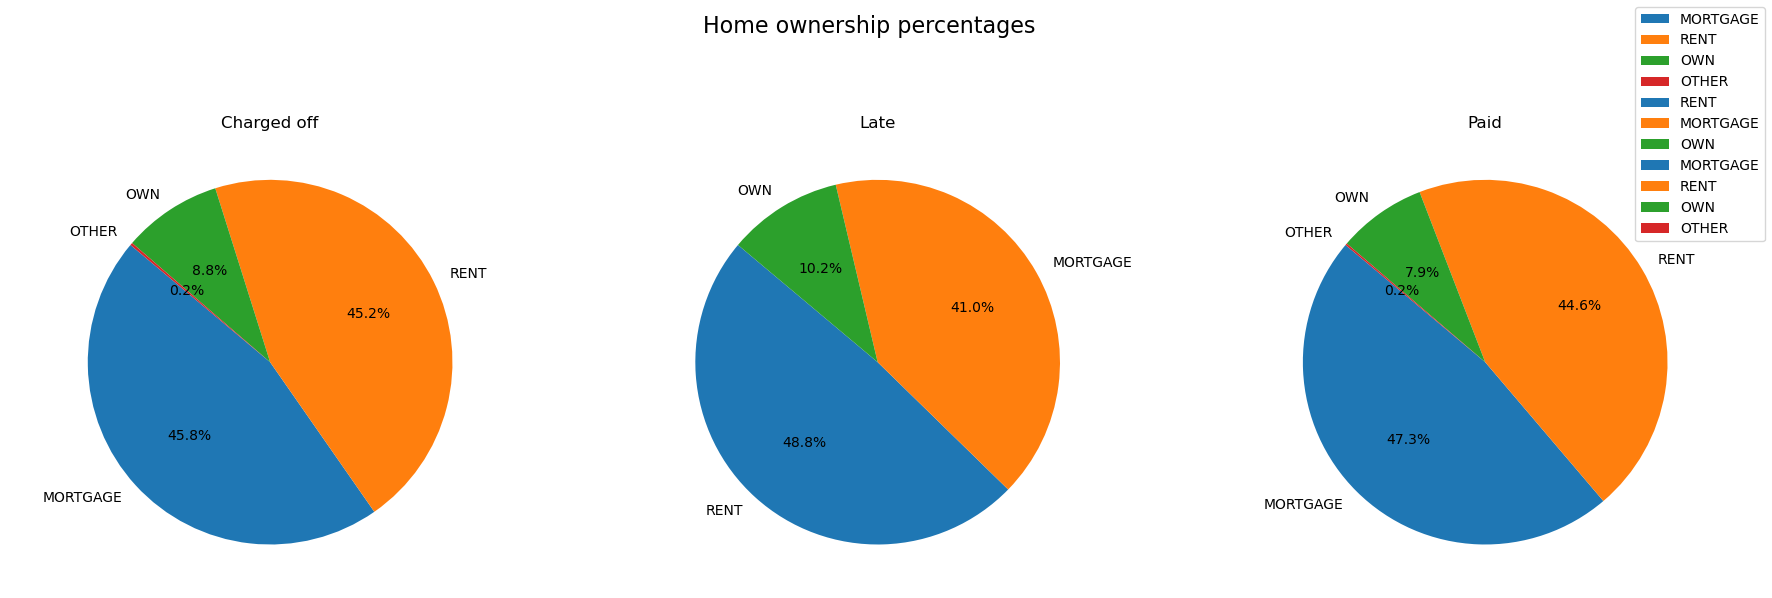

In [17]:
charged_count = charged_off_df['home_ownership'].value_counts()
late_count = late_df['home_ownership'].value_counts()
paid_count = paid_df['home_ownership'].value_counts()
# The subplots grid is 1 x 3
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# charged off grades
ax1.pie(charged_count, labels=charged_count.index, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')
ax1.set_title('Charged off')  # Set title for ax1
ax1.grid(True)
# late grades
ax2.pie(late_count, labels=late_count.index, autopct='%1.1f%%', startangle=140)
ax2.axis('equal')
ax2.set_title('Late')
ax2.grid(True)
# paid grades
ax3.pie(paid_count, labels=paid_count.index, autopct='%1.1f%%', startangle=140)
ax3.axis('equal')
ax3.set_title('Paid')
ax3.grid(True)
# Add plot labels and legend to the entire figure
fig.suptitle('Home ownership percentages', fontsize=16)
fig.legend(loc='upper right')
# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.9])
ax3.grid(True)
# Show the plot
plt.show()

Looking at these graphs, the distribution of the types of home ownership doesn't seem to differ much between the three status types. Thus it's unlikely that home ownership is an indicator of loss.

In [34]:
# Chi-Squared test
contingency_table = pd.crosstab(new_df['loan_status'], new_df['verification_status'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square statistic = {chi2}")
print(f"p-value = {p}")

Chi-square statistic = 983.0962080246146
p-value = 4.657133748747839e-199


Even with the consideration of the size of the dataframe, this p-value is significantly small. Thus this is evidence to suggest that their is a correlation between the verification status and the loan status. Thus suggesting that verfication status is an indicator of loss.